In [23]:
import os
import numpy as np


import torch 
import librosa
import timm
import pandas as pd
import torch.nn as nn

import IPython.display as ipd
import matplotlib.pyplot as plt

from audioset_tagging_cnn.pytorch.models import Wavegram_Logmel_Cnn14
from audioset_tagging_cnn.pytorch.pytorch_utils import do_mixup

from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from torch.nn import functional as F

from model import Model
from torch.distributions.beta import Beta

from torchlibrosa.stft import Spectrogram, LogmelFilterBank
from torchlibrosa.augmentation import SpecAugmentation

import librosa.display
import matplotlib.pyplot as plt

from functools import partial
from timm.models.efficientnet import tf_efficientnet_b0_ns

In [57]:
from sklearn.model_selection import StratifiedKFold

FOLDS = 5
SEED = 42

train = pd.read_csv("train_tp.csv").sort_values("recording_id")
ss = pd.read_csv("sample_submission.csv")

gr = pd.read_csv("train_grouped.csv")

train_gby = train.groupby("recording_id")[["species_id"]].first().reset_index()
train_gby = train_gby.sample(frac=1, random_state=SEED).reset_index(drop=True)
train_gby.loc[:, 'kfold'] = -1

X = train_gby["recording_id"].values
y = train_gby["species_id"].values

kfold = StratifiedKFold(n_splits=FOLDS)
for fold, (t_idx, v_idx) in enumerate(kfold.split(X, y)):
    train_gby.loc[v_idx, "kfold"] = fold

train = train.merge(train_gby[['recording_id', 'kfold']], on="recording_id", how="left")
# print(train.kfold.value_counts())
train.to_csv("train_tp_folds.csv", index=False)
# ids = train_gby[['recording_id', 'kfold']][train_gby['kfold'] == 0]

gr[train_gby['kfold'] == 0]
# ids

,recording_id,species_id
0,003bec244,14
1,006ab765f,23
2,007f87ba2,12
3,0099c367b,17
4,009b760e6,10
...,...,...
313,4621de448,23
324,48a77f450,22
327,48fb5143f,20+20
335,4b4c2901c,20


In [158]:
folds = pd.read_csv('train_folds.csv')
gr[folds['kfold'] == 0]

,recording_id,species_id
0,003bec244,14
1,006ab765f,23
2,007f87ba2,12
3,0099c367b,17
4,009b760e6,10
...,...,...
313,4621de448,23
324,48a77f450,22
327,48fb5143f,20+20
335,4b4c2901c,20


In [113]:
df = pd.read_csv('train_grouped.csv')

sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

for train_idx, val_idx in sss.split(X=df, y=df['species_id']):
    
    folds.append((df.loc[train_idx],df.loc[val_idx]))

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [64]:
from torchlibrosa.stft import Spectrogram, LogmelFilterBank
from torchlibrosa.augmentation import SpecAugmentation

import math

class AttBlock(nn.Module):
    def __init__(self, in_features: int):
        super(AttBlock, self).__init__()

        self.linear = nn.Linear(in_features, 1, bias=False)
        
    def forward(self, x):
        
        '''
        x: (batch, time, features)
        '''
        
        dot_product = torch.sigmoid(self.linear(x))
        
        att_weights = dot_product / torch.sum(dot_product, dim=1).unsqueeze(2)
        
        x = torch.sum(x*att_weights, dim=1)

        return x 

class Encoder(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, 
        fmax, classes_num):
        
        super(Encoder, self).__init__()

        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        top_db = None

        # Spectrogram extractor
        self.spectrogram_extractor = Spectrogram(n_fft=window_size, hop_length=hop_size, 
            win_length=window_size, window=window, center=center, pad_mode=pad_mode, 
            freeze_parameters=True)

        # Logmel feature extractor
        self.logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=window_size, 
            n_mels=mel_bins, fmin=fmin, fmax=fmax, ref=ref, amin=amin, top_db=top_db, 
            freeze_parameters=True)

        # Spec augmenter
        self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
            freq_drop_width=8, freq_stripes_num=2)

        self.bn0 = nn.BatchNorm2d(mel_bins)
        
        fe_features = 2048
        
        self.fc1 = nn.Linear(fe_features, fe_features, bias=True)
        
        self.att_block = AttBlock(fe_features)
        
        self.fe = timm.models.resnest50d_4s2x40d(pretrained=True)
#         self.fe = timm.models.tf_efficientnet_b4_ns(pretrained=True)
        self.fe = nn.Sequential(*list(self.fe.children())[:-2])  
        
        self.fc = nn.Linear(2048, classes_num)
 
    def forward(self, input, y=None):
        """
        Input: (batch_size, data_length)"""

        x = self.spectrogram_extractor(input)   # (batch_size, 1, time_steps, freq_bins)
        x = self.logmel_extractor(x)    # (batch_size, 1, time_steps, mel_bins)

        frames_num = x.shape[2]
        
        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        
        if self.training:
            x = self.spec_augmenter(x)

        # Mixup on spectrogram
#         alpha = 0.5
#         if self.training:
#             x, y_a, y_b, lam = do_mixup(x,y, alpha)

        x = torch.cat([x,x,x], dim=1)
        x = self.fe(x)
#         print(x.shape)
        x = torch.mean(x, dim=3)

        kernel = 6
        x1 = F.max_pool1d(x, kernel_size=kernel, stride=kernel, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=kernel, stride=kernel, padding=1)
        x = x1 + x2
        print(x.shape)
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))

        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.att_block(x)
        
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.fc(x)

        x = torch.sigmoid(x)
        
        return x
        
# timm.list_models('*nest*')
m = Encoder(sample_rate=32000, 
            window_size=1024, 
            hop_size=320, 
            mel_bins=128, 
            fmin=50, 
            fmax=32000 // 2,
            classes_num=24)

x = torch.load('train_torch/e0e8ceb33.pt')
x = torch.stack([x,x])
print(m(x).shape)

torch.Size([2, 2048, 22])
torch.Size([2, 24])


In [2]:
model = Model.load_from_checkpoint(checkpoint_path="lightning_logs/version_44/checkpoints/val_acc=0.7334.ckpt")
model.eval()
device = 'cuda:3'
model.to(device);

In [55]:
w, r = librosa.load('train/003bec244.flac')
print(r)

22050


In [76]:
x = torch.load('train_torch/003bec244.pt')
print(torch.chunk(x,6)[0].shape)
segments = torch.load('train_torch_segments/003bec244.pt')

sr = 22050
start = 0
end = 50 * sr

t_max = 60 * sr

t_start = np.random.randint(start, end)
t_end = t_start + 10*sr

segment_count = 132

segment_start = math.floor(t_start / t_max * segment_count)
segment_end = math.floor(t_end / t_max * segment_count)

x[segment_start:segment_end].shape, segment_start, segment_end, segments[:,segment_start:segment_end].shape

torch.Size([220500])


(torch.Size([22]), 4, 26, torch.Size([24, 22]))

torch.Size([1323000])
torch.Size([64, 2584])
259
259
259
259
259
259
259
259
259
253


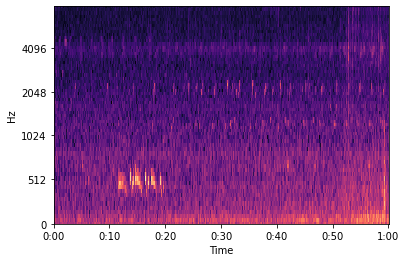

In [118]:
x = torch.load('train_torch/cd1d48eec.pt')
print(x.shape)
window = 'hann'
center = True
pad_mode = 'reflect'
ref = 1.0
amin = 1e-10
top_db = None

sample_rate=22050 
window_size=1024
hop_size=512
mel_bins=64
fmin=50
fmax=8192
classes_num=527

spectrogram_extractor = Spectrogram(n_fft=window_size, hop_length=hop_size, 
            win_length=window_size, window=window, center=center, pad_mode=pad_mode, 
            freeze_parameters=True)

# Logmel feature extractor
logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=window_size, 
    n_mels=mel_bins, fmin=fmin, fmax=fmax, ref=ref, amin=amin, top_db=top_db, 
    freeze_parameters=True)

x = spectrogram_extractor(x.unsqueeze(0))
x = logmel_extractor(x)

# y = do_mixup(x)
# print(y.shape)
x = x.transpose(1, 3).squeeze(0).squeeze(2)

print(x.shape)

librosa.display.specshow(x.numpy(),
                         y_axis='mel', fmax=8000,
                         x_axis='time')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel spectrogram')
# plt.tight_layout()

l = torch.chunk(x, 10, dim=1)
for i in l:
    print(i.shape[-1])

# plt.imshow(x[0,0])

# Spec augmenter
# spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
#     freq_drop_width=8, freq_stripes_num=2)

In [54]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]

    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]

    y_a, y_b = y, y[index]
    
    full_y = torch.clamp(y_a + y_b, 0,1)

    return mixed_x, full_y, lam

x = torch.rand(8,1,4135,128)
y = torch.rand(8,24)
mixup_data(x,y,0.5)[4]

tensor([[1.0000, 1.0000, 0.7884, 0.4697, 1.0000, 1.0000, 1.0000, 1.0000, 0.3704,
         1.0000, 0.9684, 1.0000, 1.0000, 0.9403, 1.0000, 1.0000, 1.0000, 0.5200,
         0.6462, 1.0000, 0.8470, 0.6258, 0.2846, 0.5009],
        [1.0000, 1.0000, 0.8635, 0.9250, 1.0000, 1.0000, 1.0000, 0.4451, 0.6279,
         1.0000, 0.9745, 1.0000, 0.3866, 1.0000, 0.8906, 1.0000, 1.0000, 0.8244,
         1.0000, 0.9075, 0.9273, 0.3907, 0.6700, 0.6012],
        [0.8308, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7181, 1.0000,
         1.0000, 0.6273, 1.0000, 0.3944, 1.0000, 0.7559, 0.4755, 1.0000, 1.0000,
         1.0000, 0.6824, 0.3664, 0.7245, 1.0000, 1.0000],
        [0.6887, 0.8917, 1.0000, 0.4848, 1.0000, 0.5374, 1.0000, 1.0000, 1.0000,
         0.9132, 1.0000, 1.0000, 0.8713, 1.0000, 1.0000, 0.4012, 1.0000, 0.2507,
         0.7833, 0.7708, 0.6224, 0.9245, 0.8748, 1.0000],
        [0.3716, 0.8408, 0.3010, 0.1550, 1.0000, 0.2317, 0.7304, 0.2922, 0.9374,
         1.0000, 1.0000, 1.0000, 0.5936

0.558103591084459

In [49]:
# print(x)
# torch.roll(x,1,0)

In [44]:
from torch.utils import data
from torch.utils.data import DataLoader

class TestDataset(data.Dataset):

    def __init__(self, data_dir):

        self.data_dir = data_dir
        self.files = os.listdir(data_dir)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        
        file = self.files[index]
            
        w = torch.load(self.data_dir + file)
        
        return w, file[:-3]
    
test_dataset = TestDataset('test_torch/')

batch_size = 8
num_workers = 16

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    drop_last=False, 
    num_workers=num_workers, 
    pin_memory=True)


In [50]:
for W,F in tqdm(test_loader):
    
    with torch.no_grad():

        y_hat = model(W.to(device))
        
        for index, image_id in enumerate(F): 
            
            l = y_hat[index,:].tolist()
            l = list(map(lambda x: round(x,2), l))
            sub_df.loc[image_id]= l
            

# sub_df
sub_df.to_csv('submission.csv')

100%|██████████| 249/249 [02:27<00:00,  1.68it/s]


In [21]:
import csv
df = pd.read_csv('train_tp.csv')
# df.recording_id.value_counts()

grouped = df[['recording_id','species_id']].groupby('recording_id')

def agg(l):
    s = ''
    for i in l:
        s = s + str(i) + '+'
    return s[:-1]
    
d = grouped.aggregate(agg)
d = d.reset_index()

# d.to_csv('train_grouped.csv', index=False)
# for i in d.species_id:
#     print(i.split('+'))
# d.species_id.str.len().sort_values()
# d[d.species_id > 24]

In [47]:
import math

tensor_dict = {}

segment_count = 132

for index, row in df.iterrows():
    
    rec_id = row['recording_id']
    
    if not rec_id in tensor_dict:
        tensor_dict[rec_id] = torch.zeros(24,segment_count)
    
    start_segment = math.floor(float(row['t_min']) / 60.0 * segment_count - 1)
    end_segment = math.floor(float(row['t_max']) / 60.0 * segment_count - 1)
    
    class_id = row['species_id']
    
    tensor_dict[rec_id][class_id,start_segment:end_segment] = 1
    
#     print(start_segment, float(row['t_min']))
    

for k, v in tensor_dict.items():
    torch.save(v, 'train_torch_segments/' + k + '.pt')
    

In [50]:
len(os.listdir('train_torch')), len(tensor_dict)

(1133, 1132)

In [52]:
df.f_min.min()

93.75

In [210]:
df = pd.read_csv('train_grouped.csv')

train, test = train_test_split(df, test_size=0.2)
    
train

,recording_id,species_id
366,533ae3f85,18
499,6eb03e9ca,7
838,bd97b0335,11
964,d86155abb,1
800,b4a3fb69c,17
...,...,...
46,09a946316,23
602,83028db30,11
240,3458e20b8,10
519,7341161bd,17


In [233]:
m = nn.Sigmoid()
# loss = nn.BCELoss()
input = torch.randn(1,1, requires_grad=True)
target = torch.empty(1,1).random_(2)
output = F.binary_cross_entropy(m(input), target)
target, m(input), output
# output.backward()

(tensor([[1.]]),
 tensor([[0.5811]], grad_fn=<SigmoidBackward>),
 tensor(0.5429, grad_fn=<BinaryCrossEntropyBackward>))

In [3]:
pd.read_csv('sample_submission.csv')

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,003bc2cb2,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,0061c037e,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,010eb14d3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,011318064,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,ff68f3ac3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1988,ff973e852,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1989,ffa5cf6d6,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1990,ffa88cbb8,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
